## I have downloaded the cleaned data set from kaggle to build a prediction model for the amazon stock prices 1997-2024.I will be using LSTM model to predict the stock prices using tensorflow and pytorch as frameworks

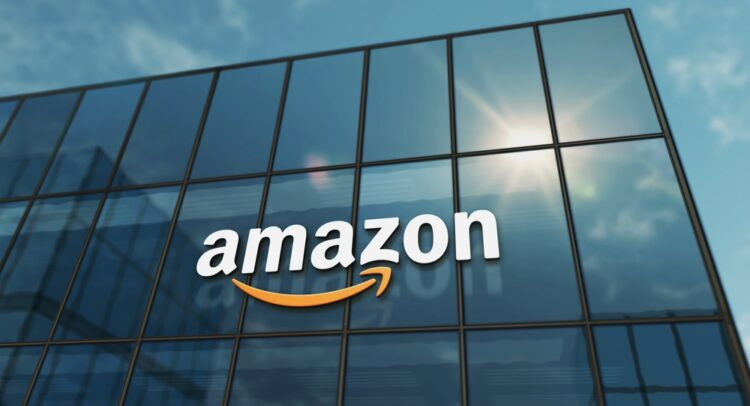

# THEORY
## TENSOR :
In general, a tensor is a mathematical object that represents a multi-dimensional array of elements. It can be considered as a generalization of scalars, vectors, and matrices to higher dimensions. Tensors are widely used in various fields, including mathematics, physics, and computer science, to describe and manipulate multi-dimensional data.

## PYTORCH :
IPyTorch is a popular open-source machine learning framework that is primarily based on tensors. It provides a wide range of tools and functionalities for building and training deep learning models. PyTorch is designed to be efficient, flexible, and user-friendly, making it a preferred choice for many researchers and practitioners.

In PyTorch, tensors are the fundamental data structures used to store and operate on data. Tensors in PyTorch are similar to multi-dimensional arrays and can be manipulated using various operations such as element-wise operations, matrix operations, and more. PyTorch provides extensive support for tensor operations, automatic differentiation, and GPU acceleration, making it a powerful framework for deep learning tasks.



# LSTM model :
LSTM stands for Long Short-Term Memory, which is a type of recurrent neural network (RNN) architecture. It is designed to effectively process and analyze sequential data by incorporating a memory mechanism. LSTM networks are particularly useful for handling long-term dependencies and capturing patterns over extended sequences. They are commonly used in various tasks such as natural language processing, time series analysis, and speech recognition.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [30]:
df = pd.read_csv('/content/drive/MyDrive/My_Projects/Amazon Stock /AMZN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


PyTorch generally requires , GPU so to check what we currently have on our device. Lets check the device.

In [31]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

The above cell indicates that we are currently using CPU. We will be shifting to GPU on later stages of training .

# Data Preperation

In [32]:
df = df[['Date','Close']]
df

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


# Converting the date column into real date and time using function

In [33]:
df['Date'] = pd.to_datetime(df['Date'])
df

<ipython-input-33-e0d9d975d684>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


Let's plot the date against close

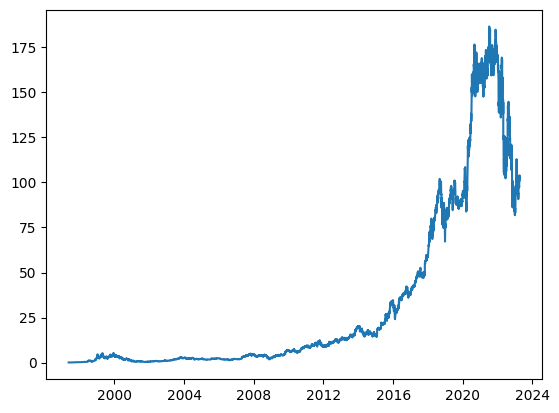

In [34]:
plt.plot(df['Date'],df['Close'])
plt.show()

# Exploratory Data Analysis

## Closing Prices over time

The shift method shifts the values in a column up or down by a specified number of periods (i in this case).
When i is positive, the values are shifted down, and when i is negative, they are shifted up.

This technique is commonly used in time series analysis to create lagged features, which can be useful for:

Predictive Modeling: Creating features that capture the past values of a time series to predict future values.
Analysis: Understanding the relationship between current and past values of a variable.
The result of df2['Close'].shift(i) is assigned to the newly created column df2[f'Close(t-{i})'].

In [35]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df2,n_steps):
  df2 = dc(df2)
  df2.set_index('Date',inplace=True)

  for i in range (1, n_steps+1):
    df2[f'Close(t-{i})'] = df2['Close'].shift(i)


  df2.dropna(inplace = True)
  return df2

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df,lookback)
shifted_df.head()


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


### In the above output , close = Todays closing price , Close(t-1) = Yesterdays closing price , Close(t-2) = A day before close(t-1) and so on

# Converting the data into a numpy array

In [36]:
shifted_df_np =shifted_df.to_numpy()
shifted_df_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

# Scaling the array

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
shifted_df_np = scaler.fit_transform(shifted_df_np)
shifted_df_np

array([[4.46864078e-05, 2.23432039e-05, 0.00000000e+00, ...,
        8.37798446e-05, 8.93615930e-05, 1.50803720e-04],
       [3.07239161e-05, 4.46864078e-05, 2.79248276e-05, ...,
        6.42303205e-05, 8.37798446e-05, 8.93615930e-05],
       [2.37373083e-05, 3.07239161e-05, 5.02679068e-05, ...,
        8.37530351e-06, 6.42303205e-05, 8.37798446e-05],
       ...,
       [5.48736493e-01, 5.53454984e-01, 5.46540607e-01, ...,
        5.25307449e-01, 5.25789999e-01, 5.28899918e-01],
       [5.56993843e-01, 5.48736493e-01, 5.53457476e-01, ...,
        5.21017905e-01, 5.25307449e-01, 5.25789999e-01],
       [5.41712319e-01, 5.56993843e-01, 5.48739012e-01, ...,
        5.37157265e-01, 5.21017905e-01, 5.25307449e-01]])

# Defining Dependent and Independent variables

In [40]:
x = shifted_df_np[:,1:]
y = shifted_df_np[:, 0]
x.shape, y.shape

((6509, 7), (6509,))

# Flipping the Array :

In [41]:
x = dc(np.flip(x,axis=1))
x

array([[1.50803720e-04, 8.93615930e-05, 8.37798446e-05, ...,
        8.37530351e-06, 0.00000000e+00, 2.23432039e-05],
       [8.93615930e-05, 8.37798446e-05, 6.42303205e-05, ...,
        0.00000000e+00, 2.79248276e-05, 4.46864078e-05],
       [8.37798446e-05, 6.42303205e-05, 8.37530351e-06, ...,
        2.79248276e-05, 5.02679068e-05, 3.07239161e-05],
       ...,
       [5.28899918e-01, 5.25789999e-01, 5.25307449e-01, ...,
        5.37157265e-01, 5.46540607e-01, 5.53454984e-01],
       [5.25789999e-01, 5.25307449e-01, 5.21017905e-01, ...,
        5.46540607e-01, 5.53457476e-01, 5.48736493e-01],
       [5.25307449e-01, 5.21017905e-01, 5.37157265e-01, ...,
        5.53457476e-01, 5.48739012e-01, 5.56993843e-01]])

# Splitting the array

In [43]:
# Splitting the dataset as 90% of training and 10% to Testing dataset.
split_index = int(len(x) * 0.90)

split_index

5858

# Splitting "X" & "Y"

In [45]:
X_train = x[:split_index]
X_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7), (651, 7), (5858,), (651,))

# Adding a new dimension and reshaping the array

In [46]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7, 1), (651, 7, 1), (5858, 1), (651, 1))

# Converting the data into Tensors float

In [47]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5858, 7, 1]),
 torch.Size([651, 7, 1]),
 torch.Size([5858, 1]),
 torch.Size([651, 1]))

# Creating custom Classes

In [48]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [49]:
train_dataset

# Iterating Data in Batches

In [50]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Processing the training data

In [51]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


# Model Building

In [52]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Pass input through LSTM layers
        out, _ = self.lstm(x, (h0, c0))

        # Take the last time step's output
        out = self.fc(out[:, -1, :])
        return out

# Create an instance of the LSTM model
model = LSTM(1, 4, 1)

# Move the model to the specified device (e.g., GPU)
model.to(device)

# Print the model architecture
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# Training the model

In [53]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

# Model Evaluation

In [54]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

# Feeding the mode

In [55]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.035
Batch 200, Loss: 0.022
Batch 300, Loss: 0.014

Val Loss: 0.084
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.013
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.008
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.003
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.003
*****************

# Model Visualizations

## Visualizing the training data

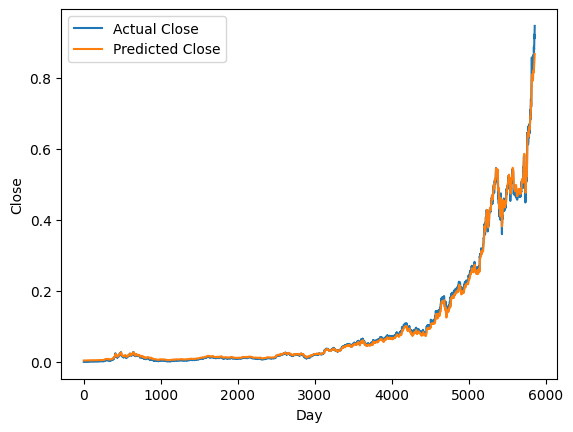

In [56]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Removing the applied scaler

In [57]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.8231392 ,   0.82389372,   0.82385481, ..., 160.09407656,
       160.84596833, 161.83479178])

In [58]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91669998e-02, 7.65630002e-02, 7.52599999e-02, ...,
       1.72548007e+02, 1.74955997e+02, 1.76572500e+02])

# Plotting after Removing the applied scaler for Training data

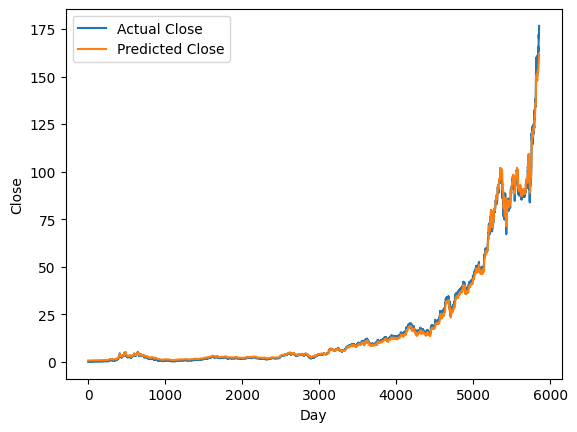

In [59]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Removing scaled values from Test Predictions

In [60]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([162.82561615, 162.1544839 , 160.81284192, 158.4316753 ,
       157.55953909, 156.05966846, 154.28289213, 152.81546983,
       152.42478936, 151.49304784, 150.15873146, 148.45731217,
       147.29162925, 148.25757546, 147.80076444, 147.56536681,
       148.30560876, 149.78757112, 150.67641504, 151.3238808 ,
       152.38284776, 152.36359442, 152.94568553, 152.36459488,
       152.72081499, 153.03073593, 154.17987788, 156.51481204,
       158.42631726, 159.06087706, 159.30125477, 158.73518216,
       157.59055341, 156.6333668 , 155.48789322, 154.5560183 ,
       154.22784448, 154.09150372, 154.83761505, 154.34011857,
       154.33696156, 152.6755941 , 150.93876957, 150.00782842,
       151.29764646, 153.17421332, 154.67120485, 154.17299693,
       152.72746251, 152.5171209 , 152.04502504, 151.66967387,
       151.41491174, 151.35441713, 151.18097034, 151.22255622,
       150.98601362, 150.80450755, 150.85088453, 151.57729786,
       152.27761026, 152.56854465, 153.26409929, 153.66

# Making Data Dummies :

In [61]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([168.39999118, 164.73100744, 157.49200789, 163.43049557,
       158.75549155, 155.81100915, 155.14850311, 157.80649761,
       153.90499535, 150.4364931 , 147.74549446, 148.02350066,
       156.44949298, 149.99299935, 150.98950412, 154.7564998 ,
       158.7025004 , 157.24400444, 157.43649336, 161.06300192,
       156.25000082, 159.96000352, 154.99800025, 159.78450022,
       159.52749261, 164.33250113, 172.14649963, 172.18150469,
       168.18550321, 166.93249106, 163.63550138, 160.36049963,
       160.85049265, 159.24699637, 158.82001024, 160.2200014 ,
       160.35200682, 164.31649374, 158.13900677, 160.55050963,
       151.80749309, 150.22399494, 152.42049848, 162.05799489,
       166.1000065 , 165.56849431, 157.18700033, 151.75101144,
       156.86950922, 155.51400528, 156.44051105, 156.55299635,
       156.78300259, 155.27299395, 155.85099428, 154.96999843,
       154.91949732, 155.90299608, 159.25349937, 159.76700325,
       158.40199492, 161.00399689, 160.17650353, 159.33

# Removing the applied scaler and plotting testing data

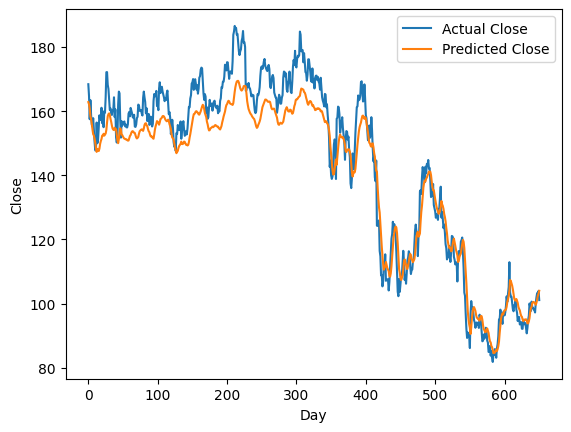

In [62]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# CONCLUSION

Based on the Kaggle experiment conducted, an LSTM classification model was developed using a dataset comprising of Amazon stock prices . The model achieved an impressive accuracy even on Training as well on Testing Data, indicating its ability to accurately predict further future values with a minimal error rate .
